In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astrotools.interpolate import GP
from astrotools.filters import zero_point
from astrotools.reader import read_osc, slice_band_generator, normalize_lc

%matplotlib inline
plt.rcParams['figure.figsize'] = 24, 20

In [9]:
OSC_list = os.listdir('/Users/szymon/Dropbox/Projects/OSC/data')
OSC_list

['iPTF13bvn.json',
 'SN2006aj.json',
 'SN2007uy.json',
 'SN2007Y.json',
 'SN2008ax.json',
 'SN2008bo.json',
 'SN2008D.json',
 'SN2010al.json',
 'SN2011dh.json',
 'SN2012ap.json',
 'SN2013ge.json']

/Users/szymon/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/szymon/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


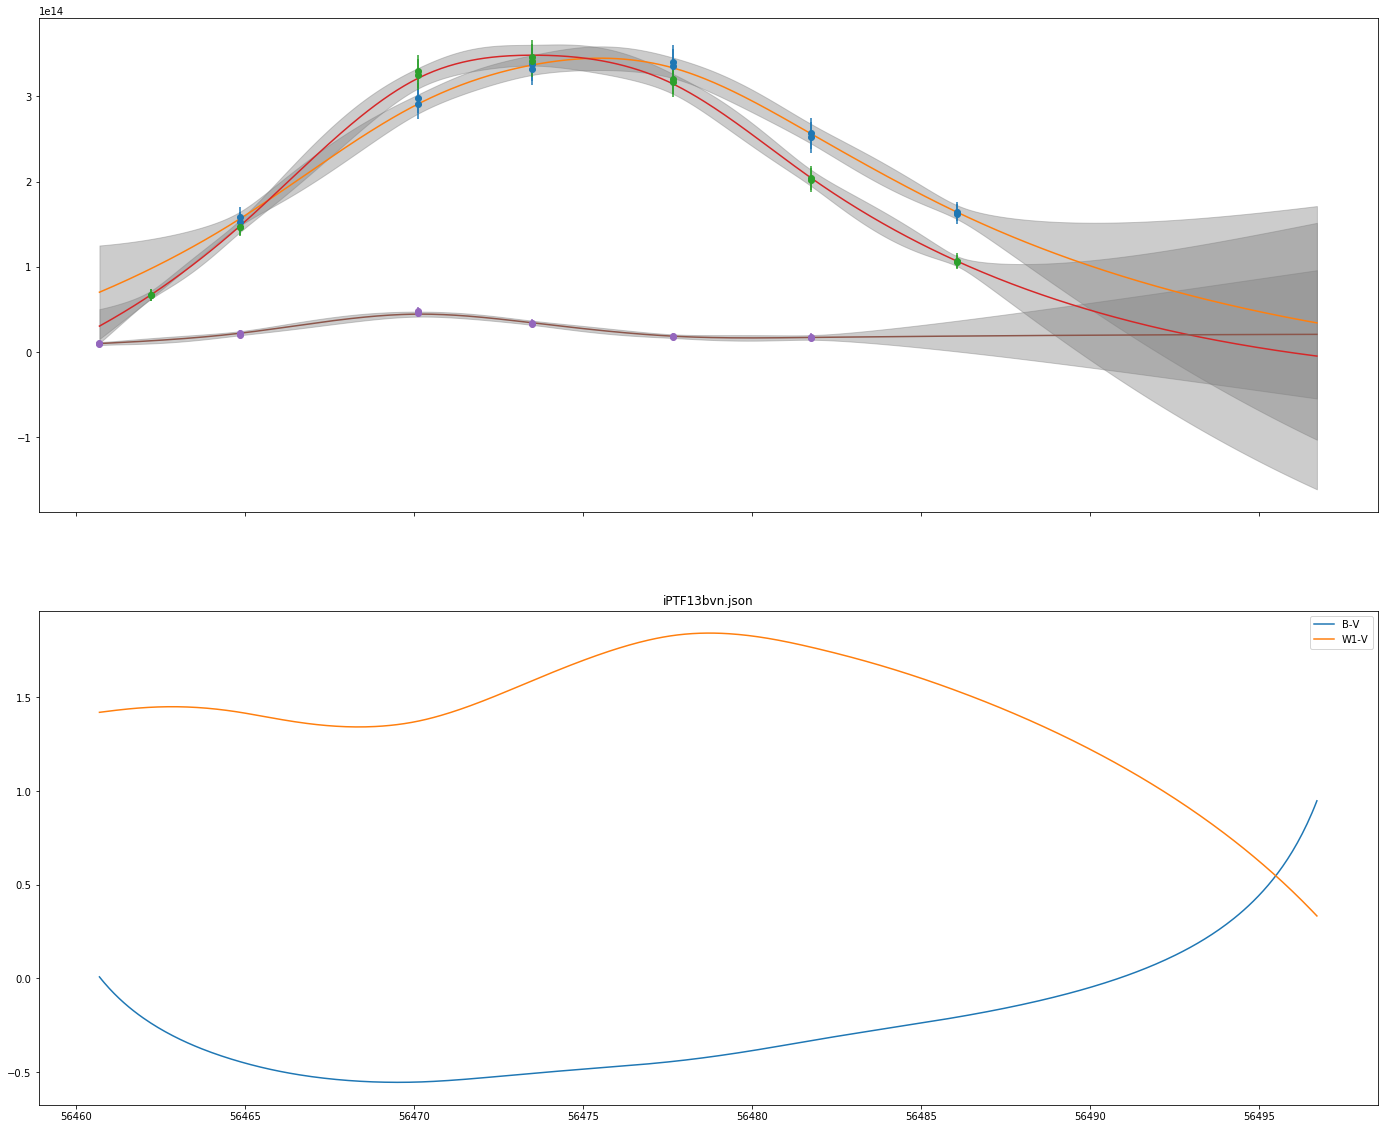

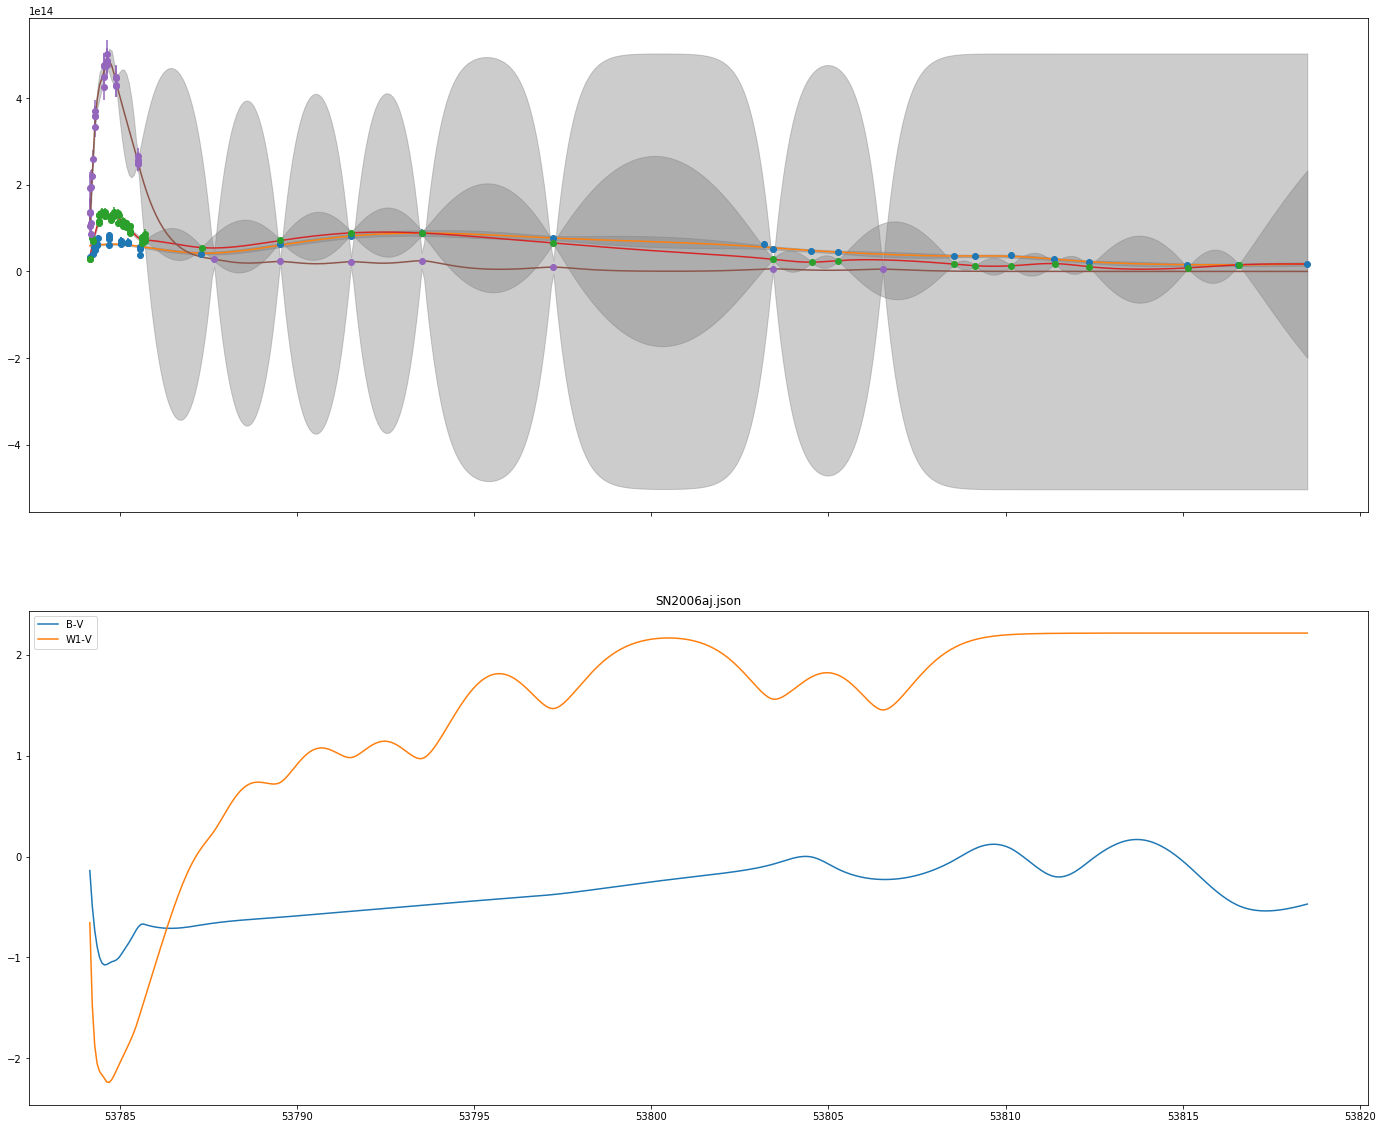

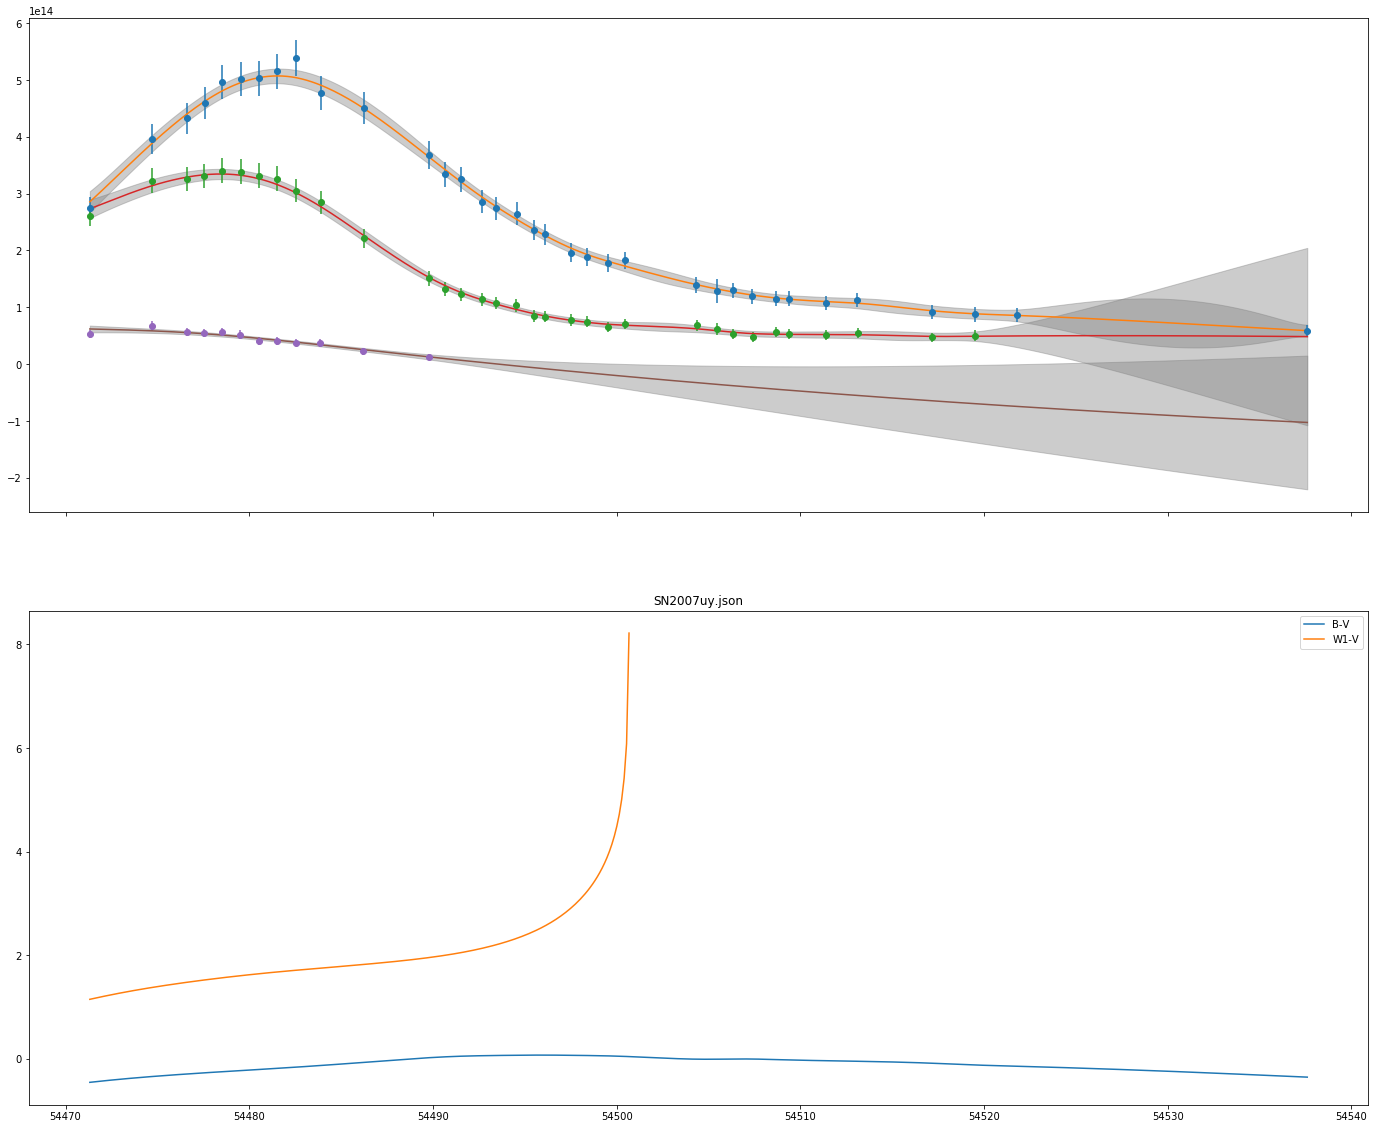

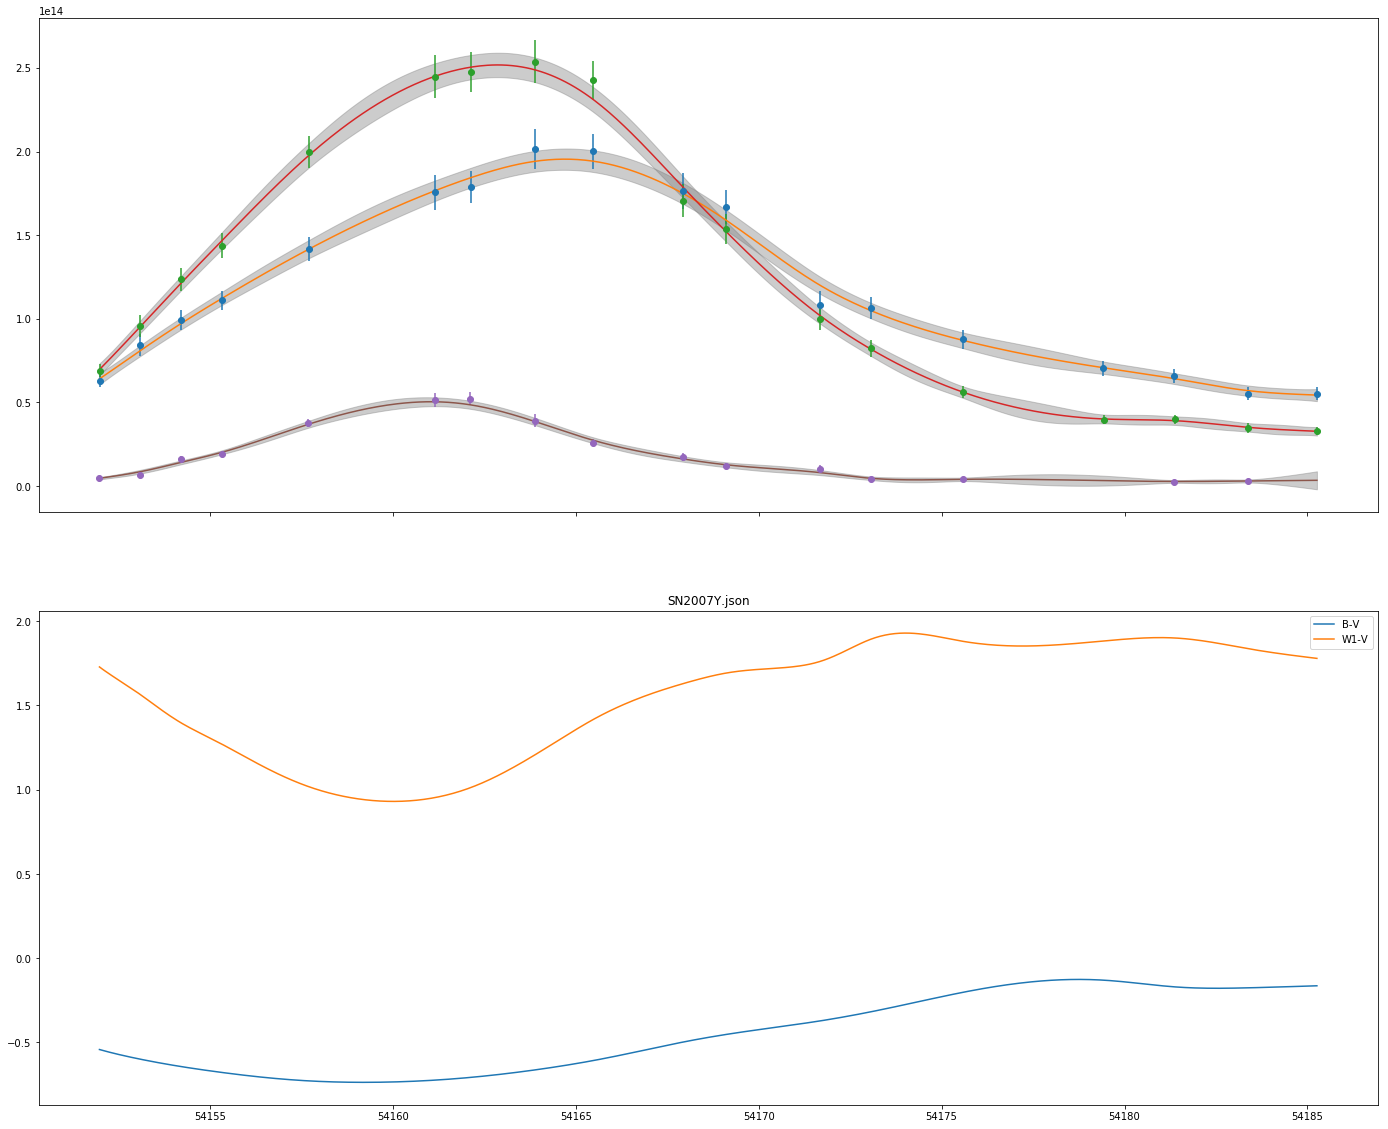

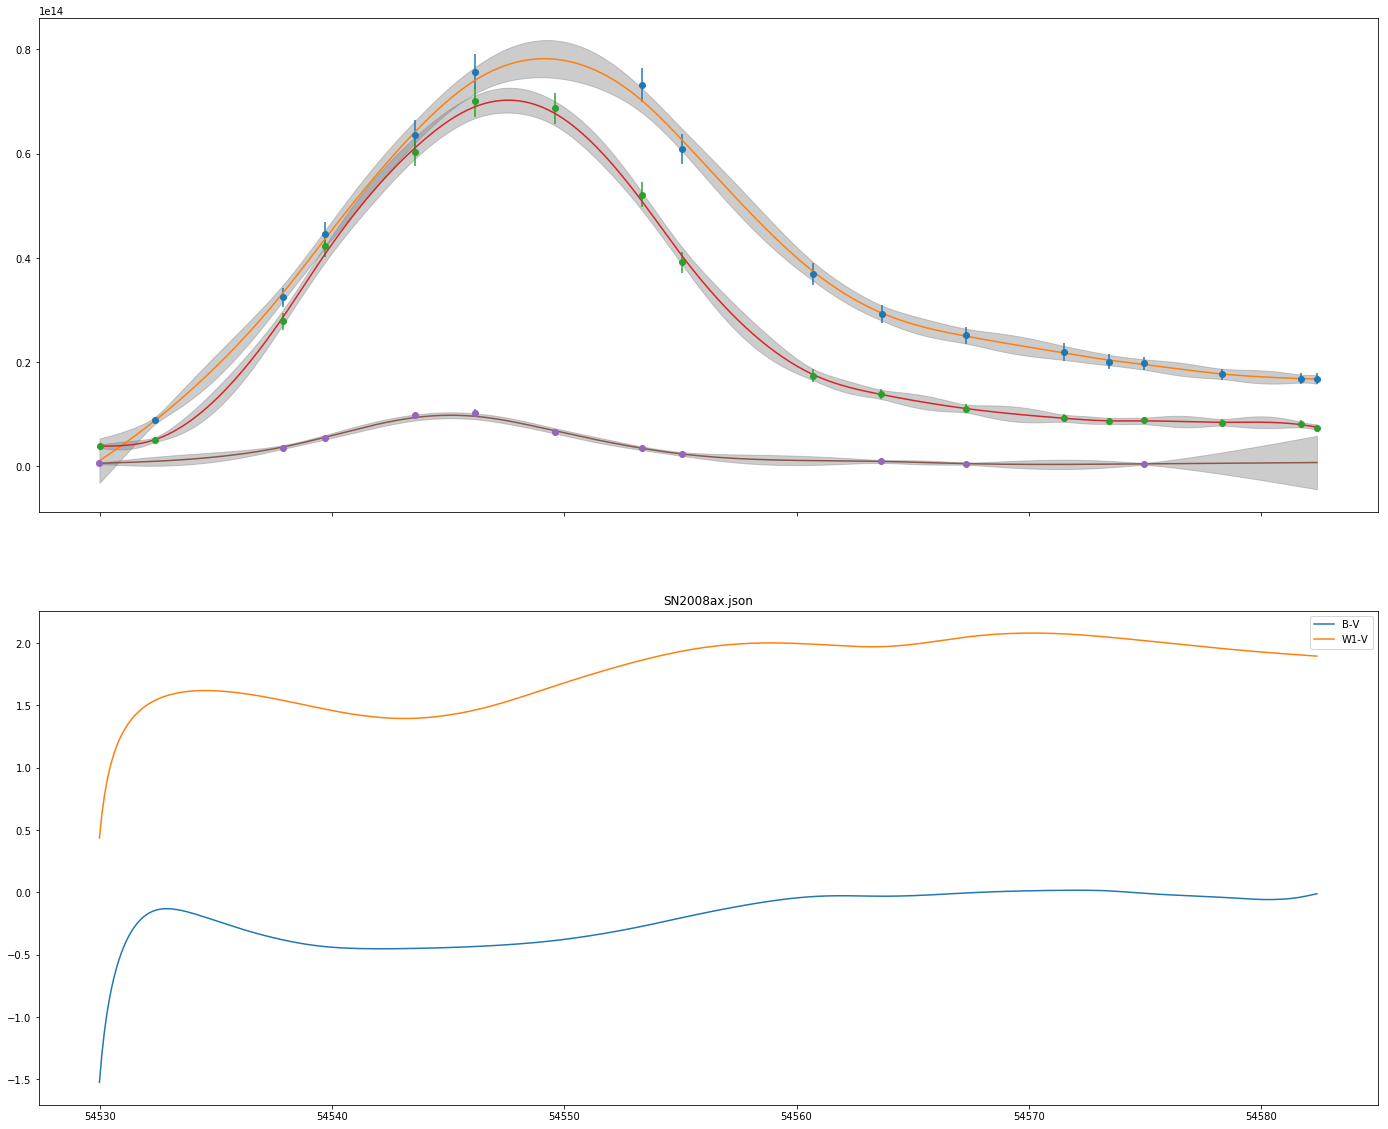

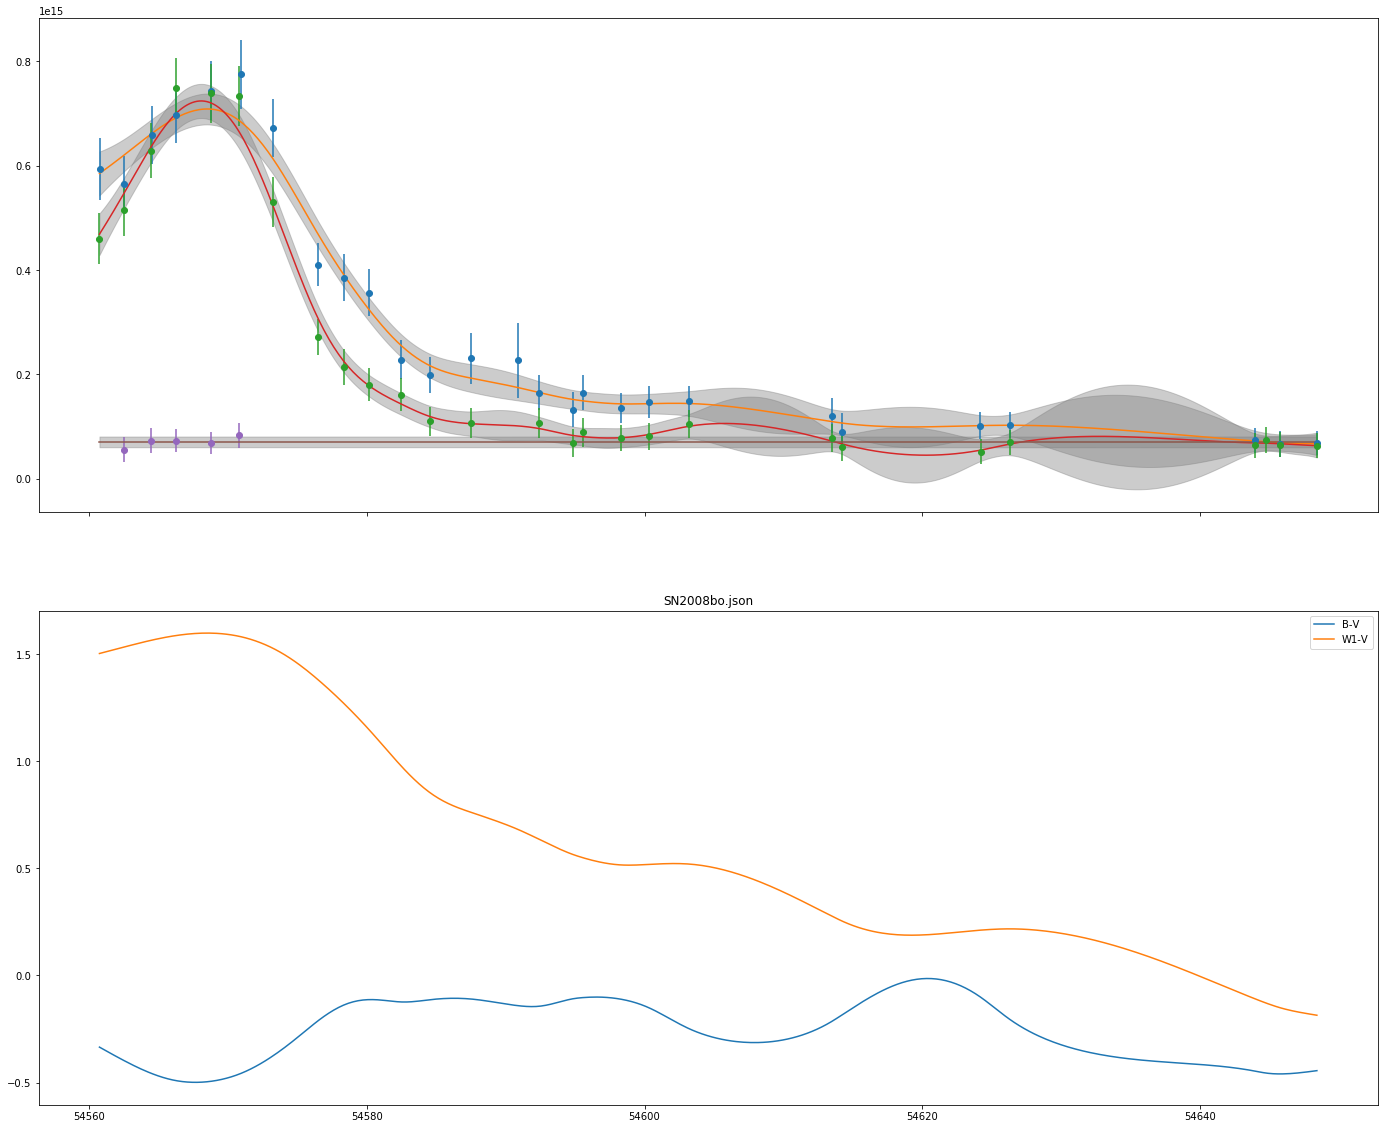

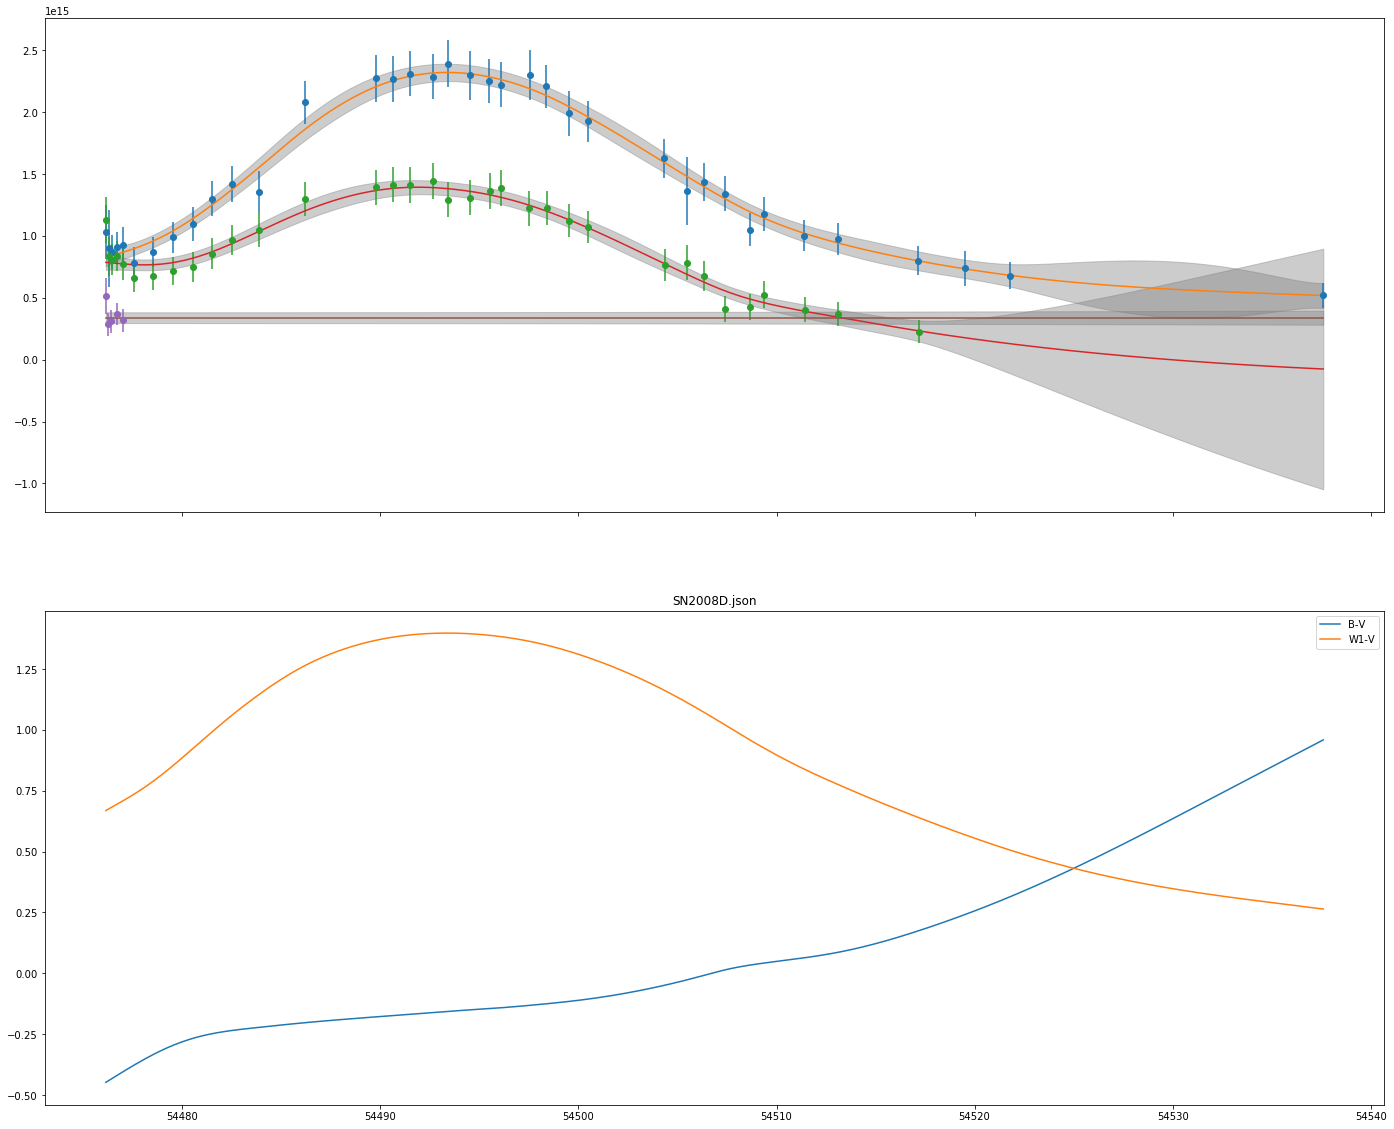

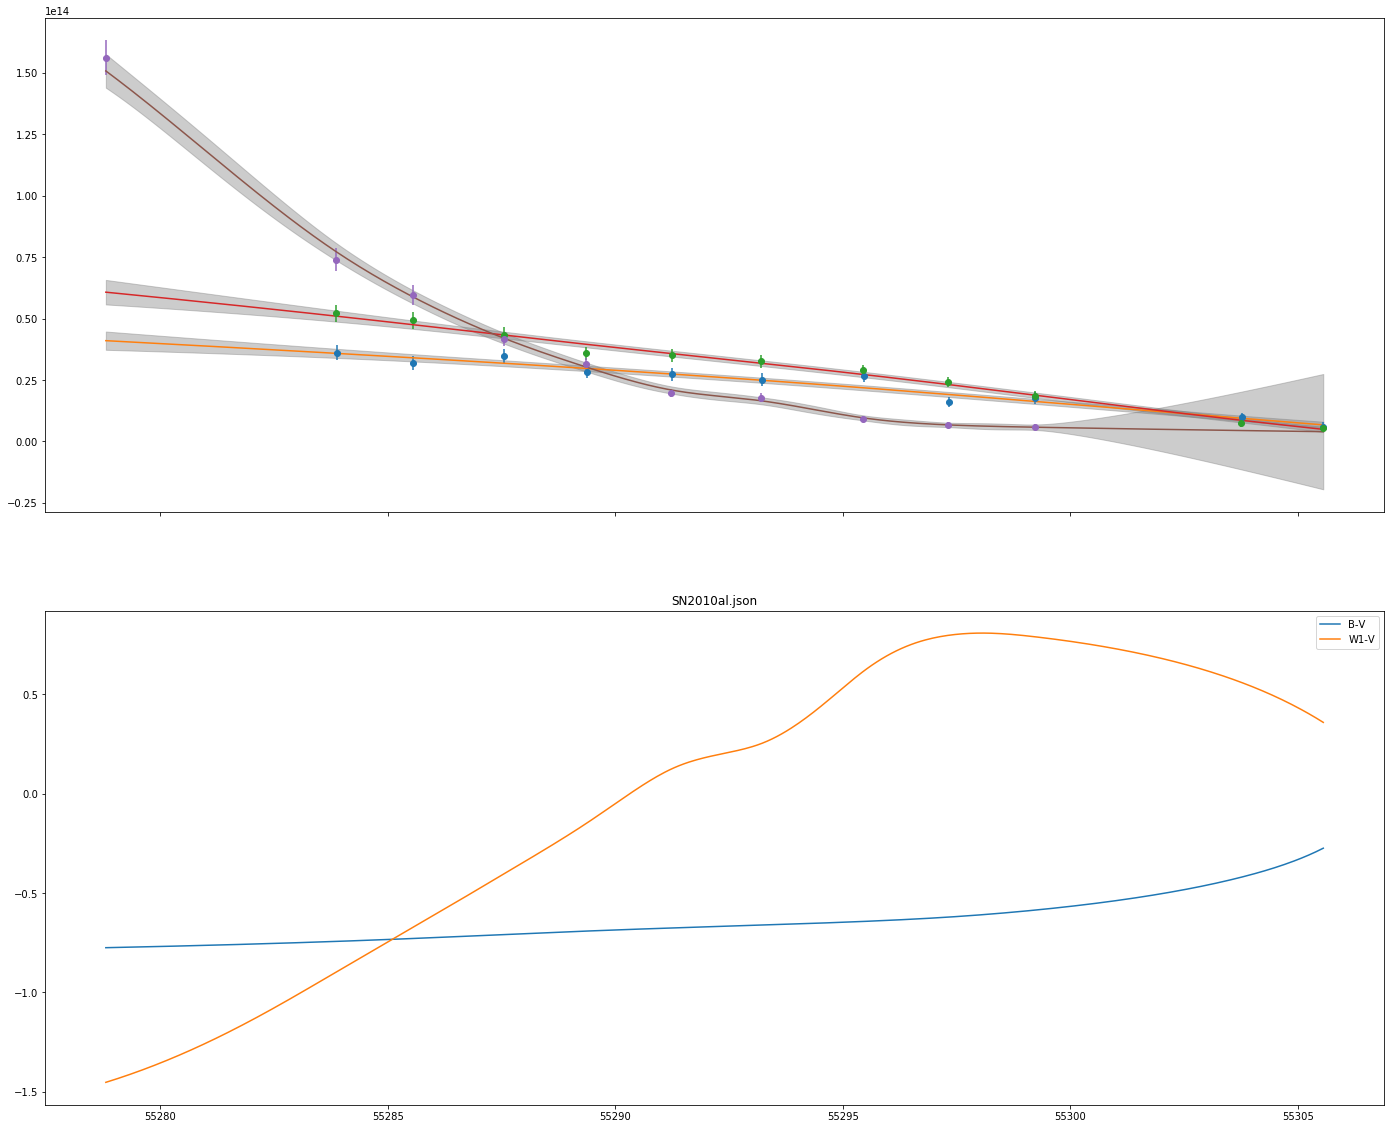

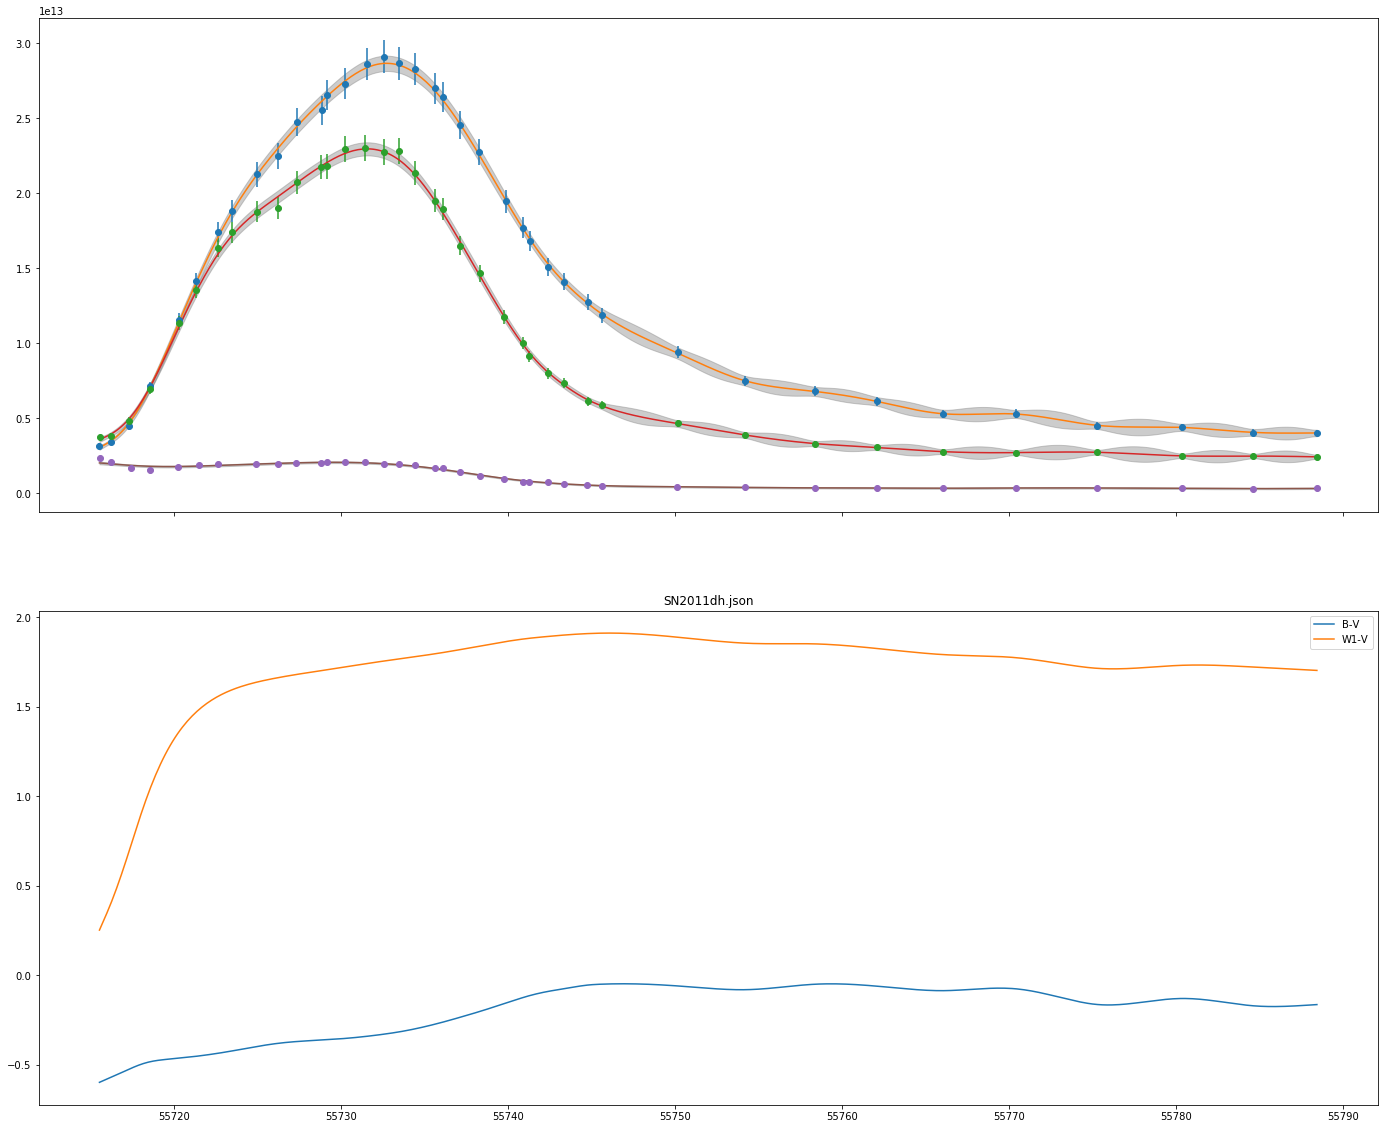

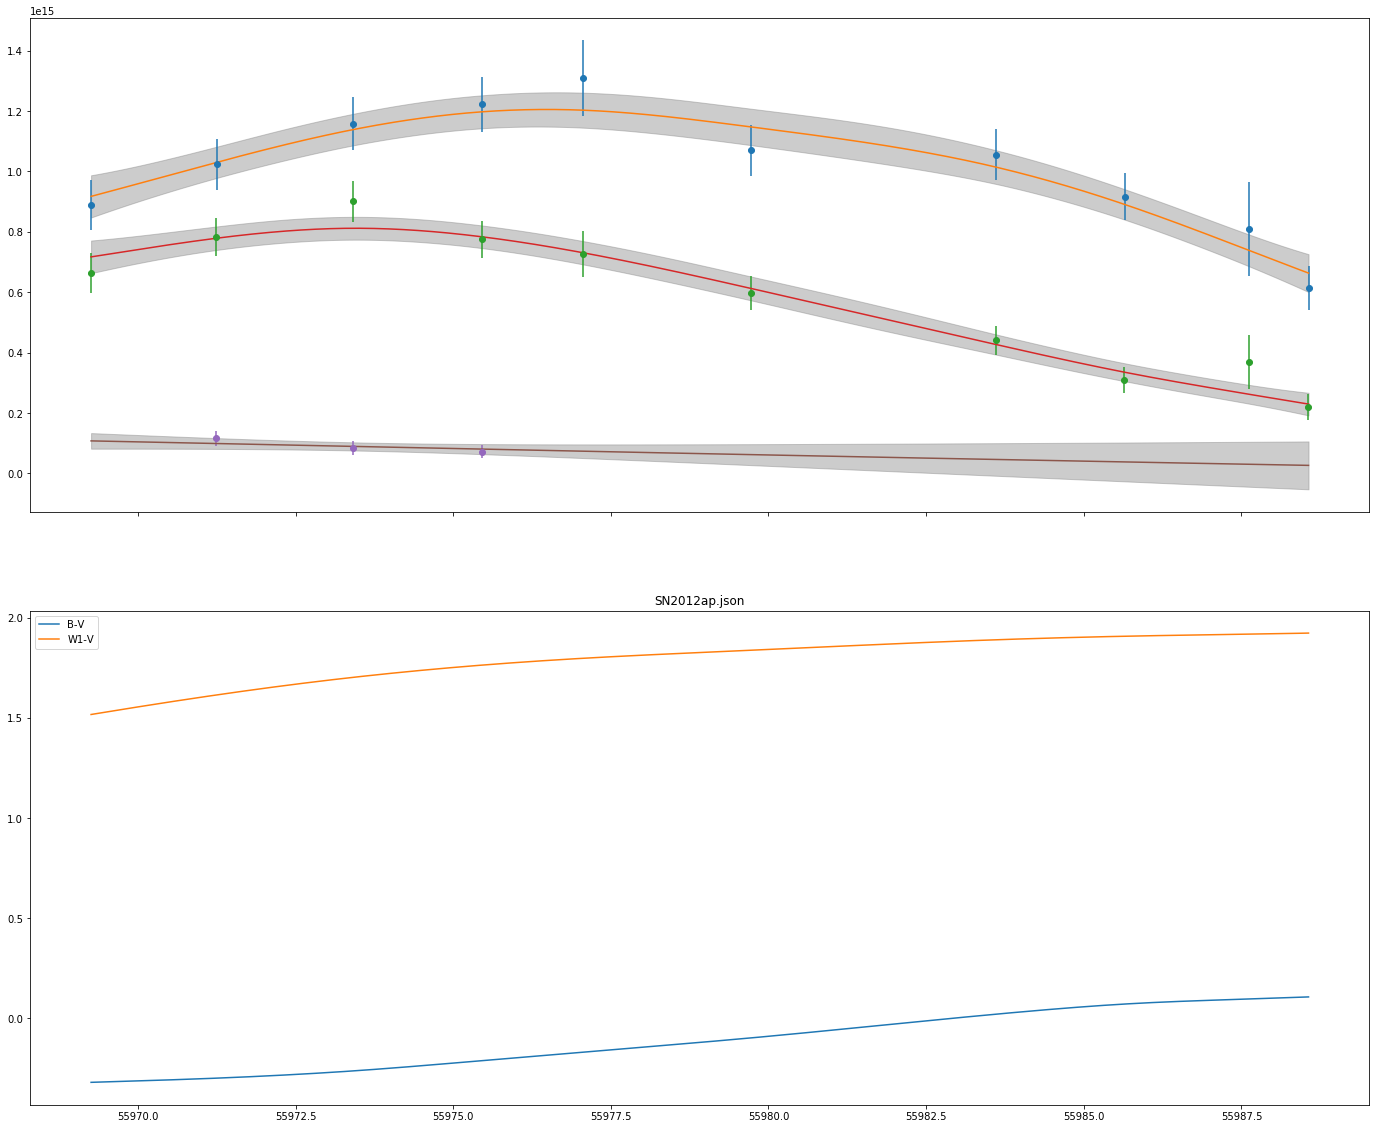

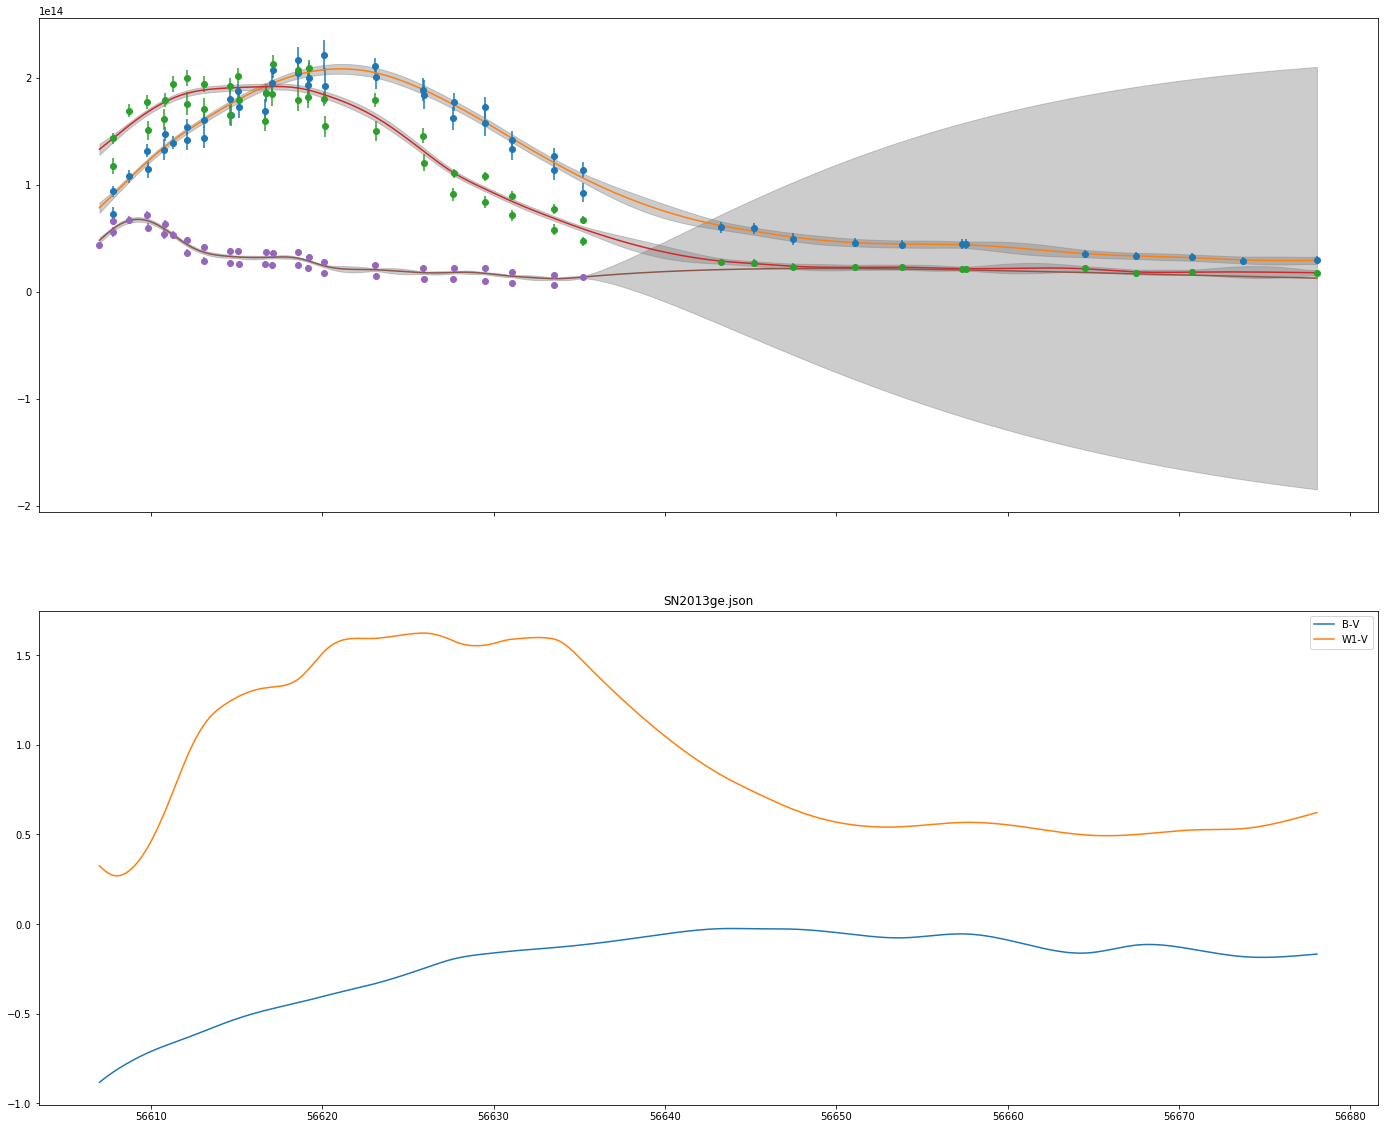

In [10]:
for SN in OSC_list:
    fig, ax = plt.subplots(2, 1, sharex=True)

    data = read_osc('/Users/szymon/Dropbox/Projects/OSC/data/' + SN)
    data = normalize_lc(data)
    data = data.query('upperlimit != True')

    x_new = np.linspace(data['mjd'].min(), data['mjd'].max(), 500)
    fit_dict = {}
    
    gp = GP()
    plt.cla()
    for data_single in slice_band_generator(data, ['V', 'B', 'W1']):
        flt = data_single['band'].values[0]
        ax[0].errorbar(data_single['mjd'], 
                     data_single['flux'] / data_single['norm_factor'].values[0], 
                     yerr=data_single['flux_err'] / data_single['norm_factor'].values[0], 
                     fmt='o', 
                     label=flt)
    
        if flt in ['V', 'B', 'W1']:
            gp.fit_reduce(data_single, init_kernel_size=100)
            mu, std = gp.predict(x_new)
            
            ax[0].plot(x_new, mu  / data_single['norm_factor'].values[0])
            ax[0].fill_between(x_new, 
                               (mu+std) / data_single['norm_factor'].values[0],
                               (mu-std) / data_single['norm_factor'].values[0],
                               alpha=0.4, color='grey')
    
            fit_dict[flt] = mu * data_single['norm_factor'].values[0]
    
    plt.legend()
    plt.title(os.path.basename(SN))
    
    zp_w1 = zero_point('W1', instrument='Swift', system='vega')
    zp_v = zero_point('V', system='vega')
    zp_b = zero_point('B', system='vega')
    
    ax[1].plot(x_new, -2.5 * np.log10((fit_dict['B'] / fit_dict['V']) + (zp_v - zp_b)), label='B-V')
    ax[1].plot(x_new, -2.5 * np.log10((fit_dict['W1'] / fit_dict['V']) + (zp_v - zp_w1)), label='W1-V')
#     ax[1].plot(x_new, -2.5 * np.log10((fit_dict['W1'] / fit_dict['B']) + (zp_b - zp_w1)), label='W1-B')
    
    plt.legend()
    plt.savefig('/Users/szymon/Desktop/testing/' + os.path.basename(SN) + '.png', bbox_inches='tight')

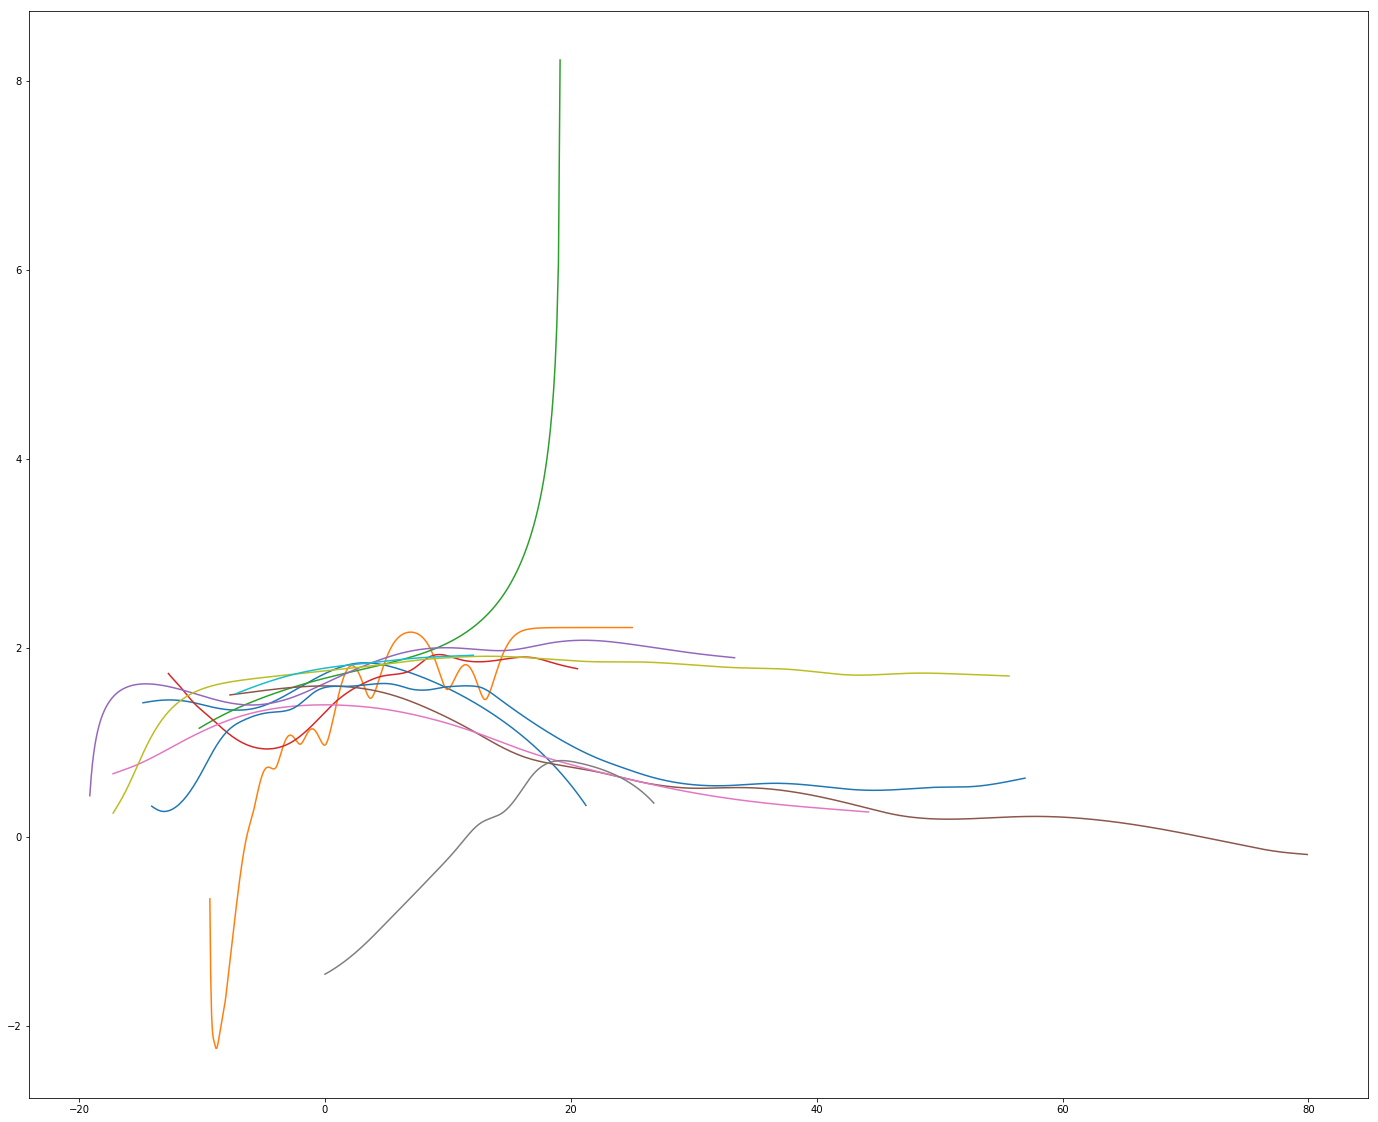

In [11]:
for SN in OSC_list:
    data = read_osc('/Users/szymon/Dropbox/Projects/OSC/data/' + SN)
    data = normalize_lc(data)
    data = data.query('upperlimit != True')

    x_new = np.linspace(data['mjd'].min(), data['mjd'].max(), 500)
    fit_dict = {}
    
    gp = GP()
    peak = 0
    for data_single in slice_band_generator(data, ['V', 'B', 'W1']):
        flt = data_single['band'].values[0]
    
        gp.fit_reduce(data_single, init_kernel_size=100)
        mu, std = gp.predict(x_new)

        fit_dict[flt] = mu * data_single['norm_factor'].values[0]

        if flt == 'V':
            peak = x_new[np.argmax(mu)]
        
    zp_w1 = zero_point('W1', instrument='Swift', system='vega')
    zp_v = zero_point('V', system='vega')
    zp_b = zero_point('B', system='vega')
    
#     plt.plot(x_new - peak, -2.5 * np.log10((fit_dict['B'] / fit_dict['V']) + (zp_v - zp_b)))
    plt.plot(x_new - peak, -2.5 * np.log10((fit_dict['W1'] / fit_dict['V']) + (zp_v - zp_w1)))